[-2.58382500e+00 -4.96283243e+00 -5.52299398e+00 -3.99939565e+00
 -1.09454256e+00  1.89017958e+00  3.71008052e+00  3.77534866e+00
  2.38707566e+00  5.05541070e-01 -8.05451144e-01 -9.48759371e-01
 -7.36421258e-02  1.07204816e+00  1.61736432e+00  1.09523379e+00
 -2.76735164e-01 -1.71695560e+00 -2.33171318e+00 -1.64319639e+00
  1.04144217e-01  2.03544949e+00  3.09363788e+00  2.60590014e+00
  6.63191928e-01 -1.89478794e+00 -3.88689434e+00 -4.37928091e+00
 -3.14905160e+00 -7.83734169e-01  1.62934275e+00  3.05496575e+00
  3.01242406e+00  1.77134069e+00  1.52509712e-01 -9.43851718e-01
 -1.02022781e+00 -2.16333025e-01  8.19409287e-01  1.33606317e+00
  9.29335148e-01 -2.18977466e-01 -1.44311916e+00 -1.97747874e+00
 -1.40637345e+00  7.33545143e-02  1.72720749e+00  2.66064130e+00
  2.29836302e+00  7.06917525e-01 -1.41544821e+00 -3.08040362e+00
 -3.50496476e+00 -2.50198062e+00 -5.63780589e-01  1.39975706e+00
  2.52608035e+00  2.42217478e+00  1.32728016e+00 -5.80219751e-02
 -9.72195871e-01 -1.00043

C:\Users\misha\AppData\Local\Temp\ipykernel_22824\469595237.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=7.5796e-18): result may not be accurate.
  a = scipy.linalg.solve([shift_x[p+i:i:-1] for i in range(p)], -x[p::])


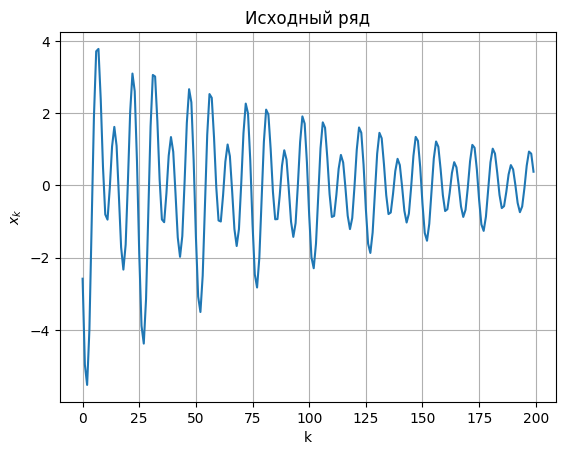

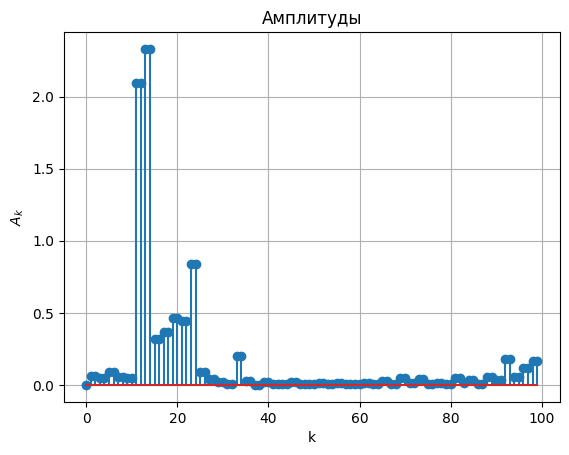

           date  mean_temp
0    2016-01-01        5.6
1    2016-01-02        6.8
2    2016-01-03        7.3
3    2016-01-04        8.3
4    2016-01-05        7.6
...         ...        ...
1456 2019-12-27        7.5
1457 2019-12-28        8.1
1458 2019-12-29        8.7
1459 2019-12-30        6.5
1460 2019-12-31        7.1

[1461 rows x 2 columns]
Количествво поворотных точек:  712

Значения ряда положительно коррелированы

t = 0.04409627483521317
Возрастяющий тренд
Hurst = 0.8423274108132863
Персистентный ряд (сохраняет тренд)
10


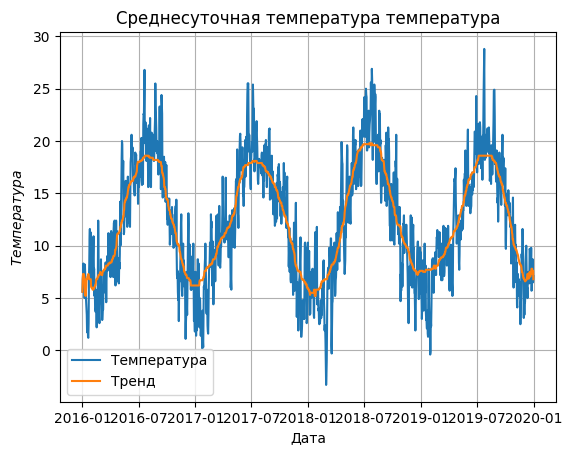

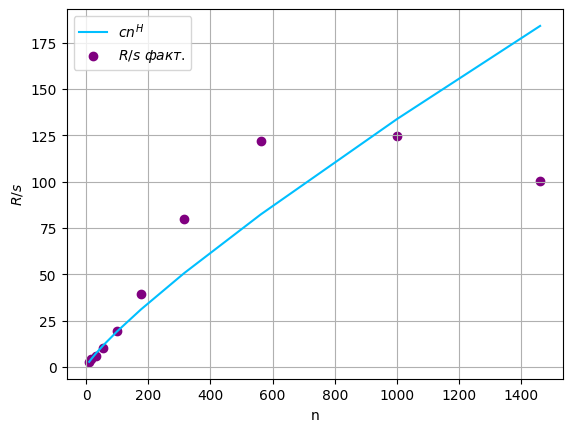

In [3]:
import math
import numpy as np
import pandas as pd
import scipy as sp
from dateutil import parser, rrule
from datetime import datetime, time, date
import scipy.linalg
import csv
from scipy import fft
from matplotlib import pyplot as plt
from hurst import compute_Hc, random_walk
N = 200
h = 0.02


def prony(x: np.array, T: float):
    if len(x) % 2 == 1:
        x = x[:len(x)-1]

    p = len(x) // 2

    shift_x = [0] + list(x)
    a = scipy.linalg.solve([shift_x[p+i:i:-1] for i in range(p)], -x[p::])

    z = np.roots([*a[::-1], 1])

    h = scipy.linalg.solve([z**n for n in range(1, p + 1)], x[:p])

    f = 1 / (2 * np.pi * T) * np.arctan(np.imag(z) / np.real(z))
    alfa = 1 / T * np.log(np.abs(z))
    A = np.abs(h)
    fi = np.arctan(np.imag(h) / np.real(h))

    return f, alfa, A, fi


def generateSample():
    return np.array([sum([(k * np.exp(-h * i / k) * np.cos(4 * np.pi * k * h * i + np.pi / k)) for k in range(1, 4)]) for i in range(1, N + 1)])


def slideMedian(sample, m):
    res = []
    for i in range(sample.size):
        if i < m:
            res.append(np.median(sample[0 : 2 * i + 1]))
        elif i >= sample.size - m - 1 :
            res.append(np.median(sample[i - (sample.size - i) : sample.size]))
        else:
            res.append(np.median(sample[i - m : i + m + 1]))
    return res


def calculateRotationPoints(sample):
    res = []
    for i in range(1, len(sample) - 2):
        if (sample[i] > sample[i - 1] and sample[i] > sample[i + 1]) or (sample[i] < sample[i - 1] and sample[i] < sample[i + 1]):
            res.append(sample[i])
    return res


def checkRotationPoints(sample, trend):
    tail = sample - trend
    rotationPoints = calculateRotationPoints(tail)

    pMean = (2.0 / 3.0) * (len(sample) - 2)
    pDisp = (16 * len(sample) - 29) / 90.0
    pSize = len(rotationPoints)

    print("Количествво поворотных точек: ", pSize)
    if pSize < pMean + pDisp and pSize > pMean - pDisp:
        print("\nРяд случаен\n")
    elif pSize > pMean + pDisp:
        print("\nРяд является быстро колеблющимся\n")
    elif pSize < pMean - pDisp:
        print("\nЗначения ряда положительно коррелированы\n")


def checkKendall(data):
    p = 0
    n = len(data)
    for i in range(len(data) - 1):
        for j in range(i+1, len(data)):
            if data[j] > data[i]:
                p += 1
    E_t = 0
    D_t = 2*(2*(len(data))+5)/(9*(len(data))*len(data)-1)
    s_t = np.sqrt(D_t)
    t = 4*p/(n*(n-1)) - 1
    print(f"t = {t}")
    if t > E_t + s_t:
        print("Возрастяющий тренд")
    elif t < E_t - s_t:
        print("Убывающий тренд")
    else:
        print("Ряд случаен")


if __name__ == "__main__":
    sample = generateSample()
    print(sample)
    plt.figure()
    plt.title("Исходный ряд")
    plt.plot(sample)
    plt.grid()
    plt.xlabel("k")
    plt.ylabel("$x_k$")
    
    f, alfa, A, fi = prony(sample, 0.1)
    plt.figure()
    plt.stem(A)
    plt.plot()
    plt.grid()
    plt.xlabel("k")
    plt.ylabel("$A_k$")
    plt.title("Амплитуды")
    plt.show()

    data_raw = pd.read_csv('LONDON.csv')
    data_raw['mean_temp'] = data_raw['mean_temp'].astype(float)
    data_raw['date'] = [datetime.strptime(str(d), '%Y%m%d') for d in data_raw['date']]
    data = data_raw.loc[:, ['date', 'mean_temp']]
    print(data)

    plt.plot(data_raw['date'], data['mean_temp'], label = 'Температура')
    trend = slideMedian(np.array(data['mean_temp']), 55)
    plt.plot(data_raw['date'], trend, label = 'Тренд')
    plt.xlabel("Дата")
    plt.ylabel("$Температура$")
    plt.title("Среднесуточная температура температура")
    plt.grid()
    plt.legend() 

    checkRotationPoints(trend, np.array(data['mean_temp']))
    checkKendall(np.array(data['mean_temp']))

    H, c, data = compute_Hc(trend, kind='random_walk', simplified=False)

    print(f"Hurst = {H}")
    if math.isclose(H, 0.5, rel_tol=1e-5):
        print("Ряд случаен")
    elif H > 0.5:
        print("Персистентный ряд (сохраняет тренд)")
    elif H < 0.5:
        print("Антиперсистентный ряд")
    
    print(len(data[0]))
    plt.figure()
    plt.plot(data[0], c*data[0]**H, color="deepskyblue", label="$cn^H$")
    plt.scatter(data[0], data[1], color="purple", label="$R/s\ факт.$")
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("$R/s$")
    plt.grid()
    plt.show()